# Imports

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
import math

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Lambda
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Huber

# Downloading Dataset

In [ ]:
# Download sunspot dataset (kaggle.com/robervalt/sunspots)

from google.colab import drive
drive.mount('/gdrive')

# Upload kaggle.json file into kaggle dir
from google.colab import files
files.upload()

# Set up kaggle dir & copy json file
! pip install -q kaggle
! mkdir '../gdrive/MyDrive/kaggle' 
os.environ['KAGGLE_CONFIG_DIR'] = '../gdrive/MyDrive/kaggle'
! cp kaggle.json ../gdrive/MyDrive/kaggle
# Set permission
! chmod 600 ../gdrive/MyDrive/kaggle/kaggle.json

# Download & unzip sunpot dataset 
!kaggle datasets download -d robervalt/sunspots
!unzip sunspots.zip  && rm sunspots.zip

! mkdir '../gdrive/MyDrive/kaggle/datasets'
! cp Sunspots.csv ../gdrive/MyDrive/kaggle/datasets

sunspot_path = '/gdrive/MyDrive/kaggle/datasets/Sunspots.csv'

print(f'\n\nListing {os.getcwd()} dir:\n')
print(os.listdir())

In [ ]:
# # If colab session disconnects

# from google.colab import drive
# drive.mount('/gdrive')
# sunspot_path = '/gdrive/MyDrive/kaggle/datasets/Sunspots.csv'

Mounted at /gdrive


# Visualising Data

In [ ]:
# Function for plotting data:
def plot_series(time, series, format='-', start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)
    if label: plt.legend()

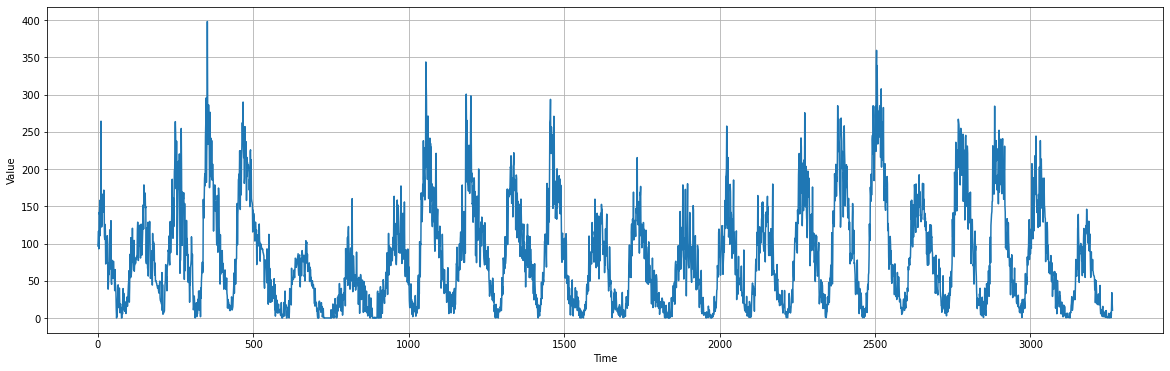

In [ ]:
# Build data as numpy arrays
time_steps = []
sunspots = []

with open(sunspot_path) as f:
    reader = csv.reader(f, delimiter=',')
    next(reader)
    for step, _, sunspot in reader: # Columns: #, Date, Monthly Mean 
        time_steps.append(int(step))
        sunspots.append(float(sunspot))

time_steps = np.array(time_steps)
sunspots = np.array(sunspots)

# View data
plt.figure(figsize=(20,6))
plot_series(time_steps, sunspots)

# Data Preprocessing

In [ ]:
# 90/10 Train/Test split

train_split = 3000

time_train = time_steps[:train_split]
x_train = sunspots[:train_split]

time_val = time_steps[train_split:]
x_val = sunspots[train_split:]

In [ ]:
# Function to build data pipeline
def window_data(data, window_size, batch_size, shuffle_buffer):
    data = tf.expand_dims(data, -1)
    ds = tf.data.Dataset.from_tensor_slices(data)
    ds = ds.window(window_size+1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

# Function to get forcasted data
def data_forecast(model, data, window_size):
    data = tf.expand_dims(data, -1)
    ds = tf.data.Dataset.from_tensor_slices(data)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

# Function to reset state & reseed
def clean_slate(seed=7):
    tf.keras.backend.clear_session()
    tf.random.set_seed(seed)
    np.random.seed(seed)

# Training with keras' LearningRateScheduler() to find optimal LR

In [ ]:
# Finding optimal learning rate
clean_slate()

# Variables
window_size = 64
batch_size = 256
shuffle_buffer = 1000

epochs = 100
lr_scheduler = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

optimizer = SGD(lr=1e-8, momentum=0.9)
loss = Huber()

# max_range to rescale data in models output Lambda layer
max_range = int(math.ceil(x_train.max()/100) * 100)

# Training data
train_set = window_data(x_train, window_size, batch_size, shuffle_buffer)

model = Sequential([
                    Conv1D(32, kernel_size=5, strides=1, 
                           padding='causal', activation='relu',
                           input_shape=[None, 1]),
                    Bidirectional(LSTM(window_size, return_sequences=True)),
                    Bidirectional(LSTM(window_size, return_sequences=True)),
                    Dense(32, activation='relu'),
                    Dense(16, activation='relu'),
                    Dense(1),
                    Lambda(lambda x: x * max_range)
])

model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])

lr_scheduler_history = model.fit(train_set, epochs=epochs, callbacks=[lr_scheduler])

Epoch 1/100
12/12 [==============================] - 13s 541ms/step - loss: 101.6080 - mae: 102.1070
Epoch 2/100
12/12 [==============================] - 7s 534ms/step - loss: 94.1628 - mae: 94.6616
Epoch 3/100
12/12 [==============================] - 7s 543ms/step - loss: 83.3264 - mae: 83.8251
Epoch 4/100
12/12 [==============================] - 7s 540ms/step - loss: 76.9504 - mae: 77.4486
Epoch 5/100
12/12 [==============================] - 7s 556ms/step - loss: 70.8914 - mae: 71.3895
Epoch 6/100
12/12 [==============================] - 7s 539ms/step - loss: 65.9163 - mae: 66.4143
Epoch 7/100
12/12 [==============================] - 7s 539ms/step - loss: 62.9307 - mae: 63.4286
Epoch 8/100
12/12 [==============================] - 7s 552ms/step - loss: 59.1983 - mae: 59.6962
Epoch 9/100
12/12 [==============================] - 7s 539ms/step - loss: 57.3339 - mae: 57.8318
Epoch 10/100
12/12 [==============================] - 7s 557ms/step - loss: 57.4153 - mae: 57.9132
Epoch 11/100
12/

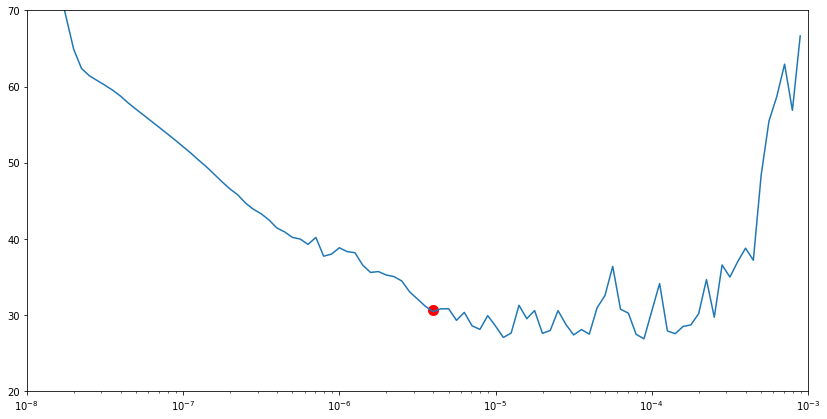

In [ ]:
# Visualise change in loss chnage due to learning rate

lrs = 1e-8 * 10**(np.arange(100)/20)
mae = lr_scheduler_history.history['mae']

plt.figure(figsize=(14, 7))
plt.semilogx(lrs, mae)
plt.axis([1e-8, 1e-3, 20, 70])



#_____________________________________________
# After ploting...
# approximetly 0.4e-5 before getting unstable
dot = 0.4e-5
plt.scatter(dot, 30.7, c='red', linewidths=5)

# Training the final model

In [ ]:
# Retrain model with optimal LR over 400 epochs

optimal_lr = 0.4e-5
optimizer = SGD(lr=optimal_lr, momentum=0.9)
loss = Huber()
epochs = 400

clean_slate()
train_set = window_data(x_train, window_size, batch_size, shuffle_buffer)

model = Sequential([
                    Conv1D(64, kernel_size=5, strides=1, padding='causal',
                           activation='relu', input_shape=[None,1]),
                    Bidirectional(LSTM(window_size, return_sequences=True)),
                    Bidirectional(LSTM(window_size, return_sequences=True)),
                    Dense(32, activation='relu'),
                    Dense(16, activation='relu'),
                    Dense(1),
                    Lambda(lambda x: x*max_range)
])

model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])

optimal_lr_history = model.fit(train_set, epochs=epochs)

Epoch 1/400
12/12 [==============================] - 12s 35ms/step - loss: 61.6588 - mae: 62.1568
Epoch 2/400
12/12 [==============================] - 0s 32ms/step - loss: 47.5806 - mae: 48.0781
Epoch 3/400
12/12 [==============================] - 0s 31ms/step - loss: 41.3920 - mae: 41.8893
Epoch 4/400
12/12 [==============================] - 0s 32ms/step - loss: 40.2566 - mae: 40.7537
Epoch 5/400
12/12 [==============================] - 0s 31ms/step - loss: 37.7948 - mae: 38.2917
Epoch 6/400
12/12 [==============================] - 0s 31ms/step - loss: 36.5132 - mae: 37.0100
Epoch 7/400
12/12 [==============================] - 0s 31ms/step - loss: 35.4265 - mae: 35.9228
Epoch 8/400
12/12 [==============================] - 0s 31ms/step - loss: 35.3376 - mae: 35.8341
Epoch 9/400
12/12 [==============================] - 0s 31ms/step - loss: 33.5201 - mae: 34.0161
Epoch 10/400
12/12 [==============================] - 1s 33ms/step - loss: 34.6727 - mae: 35.1688
Epoch 11/400
12/12 [========

In [ ]:
# Predict on entire dataset
model_forecast = data_forecast(model, sunspots, window_size)

# Slice validation
forecast_val = model_forecast[train_split-window_size+1:,-1,0]

print(forecast_val.shape == x_val.shape)

True


# Visualising the results

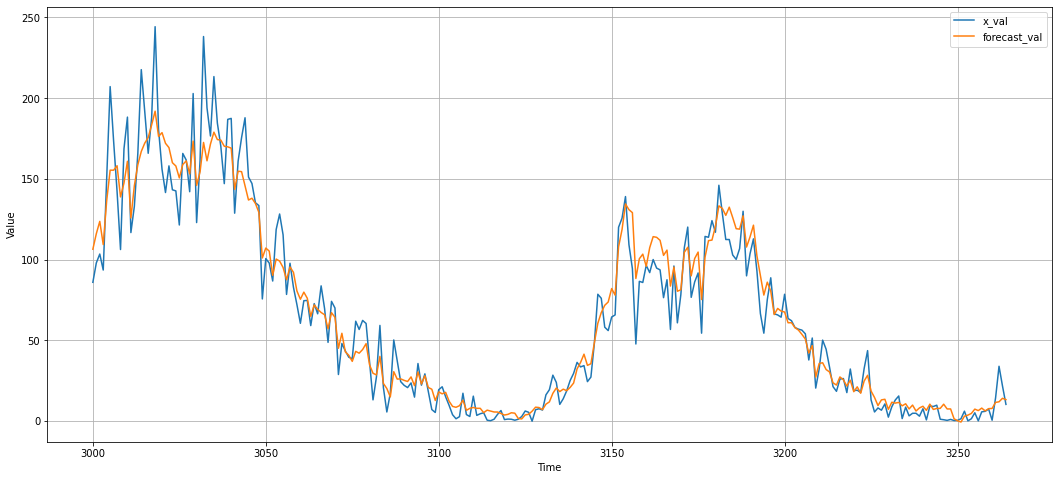

In [ ]:
# Plot val and forecasted data
plt.figure(figsize=(18,8))
plot_series(time_val, x_val, label='x_val')
plot_series(time_val, forecast_val, label='forecast_val')

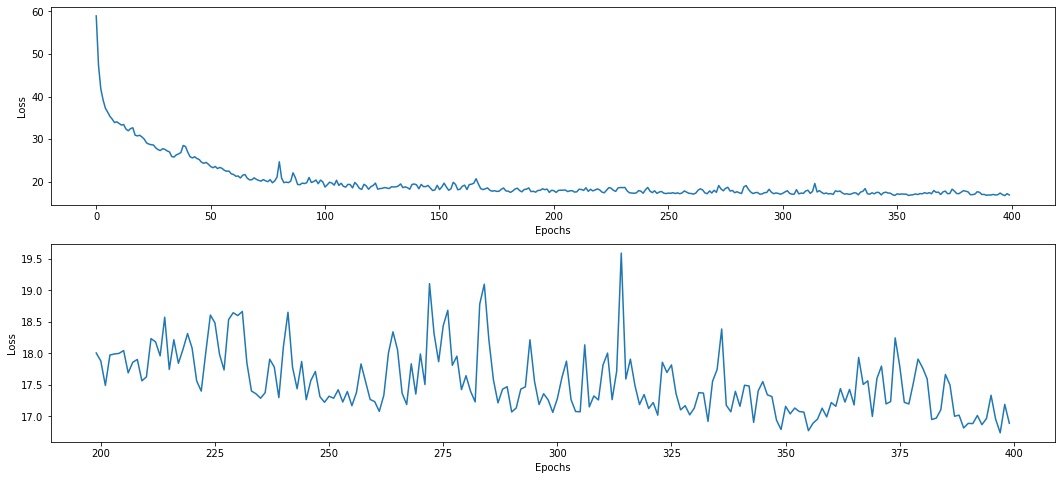

In [ ]:
# Visualising model loss

fig, (loss, loss_zoom) = plt.subplots(2,1, figsize=(18,8))

loss_list = optimal_lr_history.history['loss']
epoch_list = range(len(loss_list))

loss.set_xlabel('Epochs')
loss.set_ylabel('Loss')
loss.plot(epoch_list, loss_list)

# Zooming in
loss_list_zoom = loss_list[199:]
epoch_list_zoom = epoch_list[199:]

loss_zoom.set_xlabel('Epochs')
loss_zoom.set_ylabel('Loss')
loss_zoom.plot(epoch_list_zoom, loss_list_zoom)